In [1]:
import pandas as pd
import numpy as np

import utils.print as print_f

from utils.coco_eval import get_eval_params_dict
from utils.engine import xami_train_one_epoch, xami_evaluate, get_iou_types
from utils.plot import plot_losses, plot_train_val_ap_ars, get_ap_ar_for_train_val
from utils.save import get_data_from_metric_logger
from utils.coco_utils import get_cocos

from models.setup import ModelSetup
from models.build import create_model_from_setup
from models.train import TrainingInfo
from utils.save import check_best, end_train
from data.load import get_datasets, get_dataloaders

from IPython.display import clear_output
from utils.eval import get_ar_ap
from utils.train import get_optimiser, get_lr_scheduler, print_params_setup
from utils.init import reproducibility, clean_memory_get_device
from data.constants import DEFAULT_REFLACX_LABEL_COLS, XAMI_MIMIC_PATH
from  datetime import datetime
import torch.optim as optim

## Suppress the assignement warning from pandas.r
pd.options.mode.chained_assignment = None  # default='warn'

## Supress user warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline

In [2]:
device = clean_memory_get_device()
reproducibility()


This notebook will running on device: [CUDA]


In [3]:
use_iobb = True
io_type_str = "IoBB" if use_iobb else "IoU"
labels_cols = DEFAULT_REFLACX_LABEL_COLS
iou_thrs = np.array([0.5])


In [4]:
num_epochs = 100

In [ ]:
ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='mobilenet_v3_lr_schedule', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='mobilenet_v3', optimiser='sgd', lr=0.01, weight_decay=0.001, pretrained=True, record_training_performance=True, dataset_mode='unified', image_size=256, backbone_out_channels=16, batch_size=4, warmup_epochs=0, lr_scheduler='ReduceLROnPlateau', reduceLROnPlateau_factor=0.1, reduceLROnPlateau_patience=3, multiStepLR_milestones=[30, 50, 70, 90], multiStepLR_gamma=0.1, representation_size=32, mask_hidden_layers=256, using_fpn=False, use_mask=False, clinical_expand_dropout_rate=0, clinical_conv_dropout_rate=0, clinical_input_channels=32, clinical_num_len=9, clinical_conv_channels=32, fuse_conv_channels=32, fuse_dropout_rate=0, box_head_dropout_rate=0, fuse_depth=4)


In [11]:
## baseline, just observing the training progress with unpretrained model.
model_setup =  ModelSetup(
    name="mobilenet_v3_no_pretrained_no_lr_scheduler",
    use_clinical=True,
    use_custom_model=True,
    use_early_stop_model=True,
    backbone="mobilenet_v3",  # [mobilenet_v3]
    optimiser="sgd",
    lr=1e-1, # 1e-2
    pretrained=True,
    dataset_mode="unified",
    image_size=256,
    weight_decay=1e-3,
    record_training_performance=True,
    using_fpn=False,
    backbone_out_channels=16,  # shrink size test [16, 32]
    representation_size=32,  # shrink size test [32, 64, 128]
    # mask_hidden_layers=64,
    use_mask=False,
    batch_size=4,
    box_head_dropout_rate=0,  # [0, 0.1, 0.2, 0.3]
    warmup_epochs=0,
    lr_scheduler=None,  # [ReduceLROnPlateau, MultiStepLR]
    reduceLROnPlateau_factor=0.1,
    reduceLROnPlateau_patience=3,
    multiStepLR_milestones=[30, 50, 70, 90],
    multiStepLR_gamma=0.1,
    ## clinical
    clinical_conv_channels=32,
    fuse_conv_channels=32,
    fuse_depth=4,
) 


## Records:

# How long it take to converge?
# not very long, but the training is not stable as well.

# Does it show any overfitting?
# Nope, but it perform pretty bad on the training set.

## Does the smaller lr peform better?
# Nope, 1e-2 perform better than 1e-5 even the one with 1e-2 has unstable training progress.

## Which lr can reach the best performance?


## The one with large patience will parform better?

## As the result, we take the AP model, good?

# [TODO]:
# Run the same without using clincal data.


### basline, no pretrained
# ModelSetup(
#     name="mobilenetv3",
#     use_clinical=False,
#     use_custom_model=True,
#     use_early_stop_model=True,
#     backbone="mobilenet_v3",  # [mobilenet_v3]
#     optimiser="sgd",
#     lr=1e-2,
#     pretrained=True,
#     dataset_mode="unified",
#     image_size=256,
#     weight_decay=1e-3,
#     record_training_performance=True,
#     using_fpn=False,
#     backbone_out_channels=16,  # shrink size test [16, 32]
#     representation_size=32,  # shrink size test [32, 64, 128]
#     # mask_hidden_layers=64,
#     use_mask=False,
#     batch_size=4,
#     box_head_dropout_rate= 0 , # [0, 0.1, 0.2, 0.3]
#     warmup_epochs=0,
#     lr_scheduler = None, # [ReduceLROnPlateau, MultiStepLR]
#     reduceLROnPlateau_factor = 0.1,
#     reduceLROnPlateau_patience = 3,
#     multiStepLR_milestones= [30, 50, 70, 90] ,
#     multiStepLR_gamma =0.1,
# ),



# No lr scheduler, clinical, may need a smaller threshold
# ModelSetup(
#     name="mobilenet_v3_lr_schedule",
#     use_clinical=True,
#     use_custom_model=True,
#     use_early_stop_model=True,
#     backbone="mobilenet_v3",  # [mobilenet_v3]
#     optimiser="sgd",
#     lr=1e-2,
#     pretrained=True,
#     dataset_mode="unified",
#     image_size=256,
#     weight_decay=1e-3,
#     record_training_performance=True,
#     using_fpn=False,
#     backbone_out_channels=16,  # shrink size test [16, 32]
#     representation_size=32,  # shrink size test [32, 64, 128]
#     # mask_hidden_layers=64,
#     use_mask=False,
#     batch_size=4,
#     box_head_dropout_rate=0,  # [0, 0.1, 0.2, 0.3]
#     warmup_epochs=0,
#     lr_scheduler=None,  # [ReduceLROnPlateau, MultiStepLR]
#     reduceLROnPlateau_factor=0.1,
#     reduceLROnPlateau_patience=3,
#     multiStepLR_milestones=[30, 50, 70, 90],
#     multiStepLR_gamma=0.1,
#     ## clinical
#     clinical_conv_channels=32,
#     fuse_conv_channels=32,
#     fuse_depth=4,
# ),

# No lr scheduler, low_lr, clinical, may need a smaller threshold
# ModelSetup(
#     name="mobilenet_v3_lr_schedule",
#     use_clinical=True,
#     use_custom_model=True,
#     use_early_stop_model=True,
#     backbone="mobilenet_v3",  # [mobilenet_v3]
#     optimiser="sgd",
#     lr=1e-5,
#     pretrained=True,
#     dataset_mode="unified",
#     image_size=256,
#     weight_decay=1e-3,
#     record_training_performance=True,
#     using_fpn=False,
#     backbone_out_channels=16,  # shrink size test [16, 32]
#     representation_size=32,  # shrink size test [32, 64, 128]
#     # mask_hidden_layers=64,
#     use_mask=False,
#     batch_size=4,
#     box_head_dropout_rate=0,  # [0, 0.1, 0.2, 0.3]
#     warmup_epochs=0,
#     lr_scheduler=None,  # [ReduceLROnPlateau, MultiStepLR]
#     reduceLROnPlateau_factor=0.1,
#     reduceLROnPlateau_patience=3,
#     multiStepLR_milestones=[30, 50, 70, 90],
#     multiStepLR_gamma=0.1,
#     ## clinical
#     clinical_conv_channels=32,
#     fuse_conv_channels=32,
#     fuse_depth=4,
# ),

# No pretrained, No lr scheduler, low_lr, clinical, may need a smaller threshold
# ModelSetup(
#     name="mobilenet_v3_lr_schedule",
#     use_clinical=True,
#     use_custom_model=True,
#     use_early_stop_model=True,
#     backbone="mobilenet_v3",  # [mobilenet_v3]
#     optimiser="sgd",
#     lr=1e-5,
#     pretrained=False,
#     dataset_mode="unified",
#     image_size=256,
#     weight_decay=1e-3,
#     record_training_performance=True,
#     using_fpn=False,
#     backbone_out_channels=16,  # shrink size test [16, 32]
#     representation_size=32,  # shrink size test [32, 64, 128]
#     # mask_hidden_layers=64,
#     use_mask=False,
#     batch_size=4,
#     box_head_dropout_rate=0,  # [0, 0.1, 0.2, 0.3]
#     warmup_epochs=0,
#     lr_scheduler=None,  # [ReduceLROnPlateau, MultiStepLR]
#     reduceLROnPlateau_factor=0.1,
#     reduceLROnPlateau_patience=3,
#     multiStepLR_milestones=[30, 50, 70, 90],
#     multiStepLR_gamma=0.1,
#     ## clinical
#     clinical_conv_channels=32,
#     fuse_conv_channels=32,
#     fuse_depth=4,
# ),

# No pretrained, No lr scheduler, low_lr, may need a smaller threshold
# ModelSetup(
#     name="mobilenet_v3_lr_schedule",
#     use_clinical=False,
#     use_custom_model=True,
#     use_early_stop_model=True,
#     backbone="mobilenet_v3",  # [mobilenet_v3]
#     optimiser="sgd",
#     lr=1e-5,
#     pretrained=False,
#     dataset_mode="unified",
#     image_size=256,
#     weight_decay=1e-3,
#     record_training_performance=True,
#     using_fpn=False,
#     backbone_out_channels=16,  # shrink size test [16, 32]
#     representation_size=32,  # shrink size test [32, 64, 128]
#     # mask_hidden_layers=64,
#     use_mask=False,
#     batch_size=4,
#     box_head_dropout_rate=0,  # [0, 0.1, 0.2, 0.3]
#     warmup_epochs=0,
#     lr_scheduler=None,  # [ReduceLROnPlateau, MultiStepLR]
#     reduceLROnPlateau_factor=0.1,
#     reduceLROnPlateau_patience=3,
#     multiStepLR_milestones=[30, 50, 70, 90],
#     multiStepLR_gamma=0.1,
#     ## clinical
#     clinical_conv_channels=32,
#     fuse_conv_channels=32,
#     fuse_depth=4,
# ),


# baseline, clinical
# ModelSetup(
#     name="mobilenet_v3_lr_schedule",
#     use_clinical=True,
#     use_custom_model=True,
#     use_early_stop_model=True,
#     backbone="mobilenet_v3",  # [mobilenet_v3]
#     optimiser="sgd",
#     lr=1e-2,
#     pretrained=True,
#     dataset_mode="unified",
#     image_size=256,
#     weight_decay=1e-3,
#     record_training_performance=True,
#     using_fpn=False,
#     backbone_out_channels=16,  # shrink size test [16, 32]
#     representation_size=32,  # shrink size test [32, 64, 128]
#     # mask_hidden_layers=64,
#     use_mask=False,
#     batch_size=4,
#     box_head_dropout_rate=0,  # [0, 0.1, 0.2, 0.3]
#     warmup_epochs=0,
#     lr_scheduler="ReduceLROnPlateau",  # [ReduceLROnPlateau, MultiStepLR]
#     reduceLROnPlateau_factor=0.1,
#     reduceLROnPlateau_patience=3,
#     multiStepLR_milestones=[30, 50, 70, 90],
#     multiStepLR_gamma=0.1,
#     ## clinical
#     clinical_conv_channels=32,
#     fuse_conv_channels=32,
#     fuse_depth=4,
# ),    
# A working combination.
# model_setup = ModelSetup(
#     name="ov_3",
#     use_clinical=False,
#     use_custom_model=True,
#     use_early_stop_model=True,
#     backbone="mobilenet_v3",  # [mobilenet_v3]
#     optimiser="sgd",
#     lr=1e-2,
#     pretrained=True,
#     dataset_mode="unified",
#     image_size=256,
#     weight_decay=1e-3,
#     record_training_performance=True,
#     using_fpn=False,
#     backbone_out_channels=16,  # shrink size test [16, 32]
#     representation_size=32,  # shrink size test [32, 64, 128]
#     # mask_hidden_layers=64,
#     use_mask=False,
#     batch_size=4,
#     box_head_dropout_rate= 0, # [0, ]
# )

In [6]:
print_f.print_title("Preparing for the training.")

################ Datasets ################
dataset_params_dict = {
    "XAMI_MIMIC_PATH": XAMI_MIMIC_PATH,
    "with_clinical": model_setup.use_clinical,
    "dataset_mode": model_setup.dataset_mode,
    "bbox_to_mask": model_setup.use_mask,
    "labels_cols": labels_cols,
}

detect_eval_dataset, train_dataset, val_dataset, test_dataset = get_datasets(
    dataset_params_dict=dataset_params_dict,
)

train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
    train_dataset, val_dataset, test_dataset, batch_size=model_setup.batch_size,
)

train_coco, val_coco, test_coco = get_cocos(
    train_dataloader, val_dataloader, test_dataloader
)

eval_params_dict = get_eval_params_dict(
    detect_eval_dataset, iou_thrs=iou_thrs, use_iobb=use_iobb,
)

====================Preparing for the training.====================
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!


In [7]:
data = next(iter(train_dataloader))
data = train_dataset.prepare_input_from_data(data, device)

In [ ]:
ModelSetup(
    use_clinical=True,
    use_custom_model=True,
    use_early_stop_model=True,
    name="ov_1",
    best_ar_val_model_path=None,
    best_ap_val_model_path=None,
    final_model_path=None,
    backbone="mobilenet_v3",
    optimiser="sgd",
    lr=0.01,
    weight_decay=0.001,
    pretrained=True,
    record_training_performance=True,
    dataset_mode="unified",
    image_size=256,
    backbone_out_channels=16,
    batch_size=4,
    warmup_epochs=0,
    lr_scheduler="MultiStepLR",
    reduceLROnPlateau_factor=0.1,
    reduceLROnPlateau_patience=3,
    multiStepLR_milestones=[30, 50, 70, 90],
    multiStepLR_gamma=0.1,
    representation_size=32,
    mask_hidden_layers=256,
    using_fpn=False,
    use_mask=False,
    clinical_expand_dropout_rate=0,
    clinical_conv_dropout_rate=0,
    clinical_input_channels=32,
    clinical_num_len=9,
    clinical_conv_channels=32,
    fuse_conv_channels=32,
    fuse_dropout_rate=0,
    box_head_dropout_rate=0,
    fuse_depth=4,
)


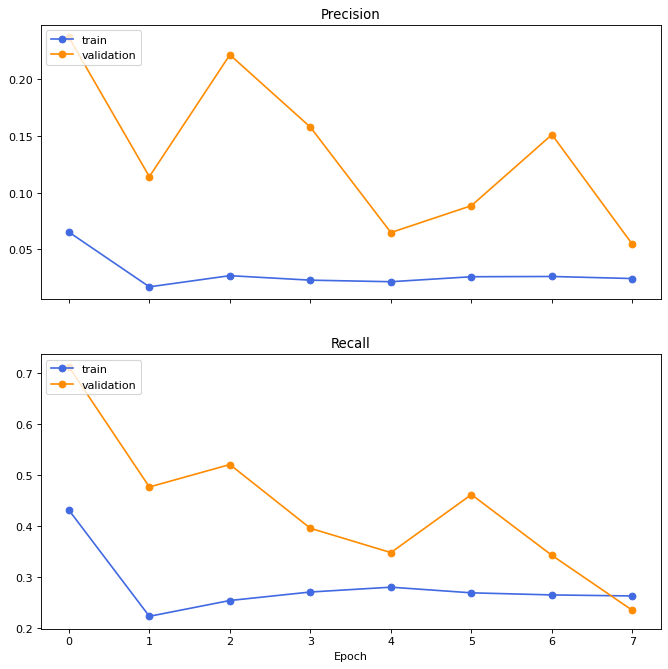

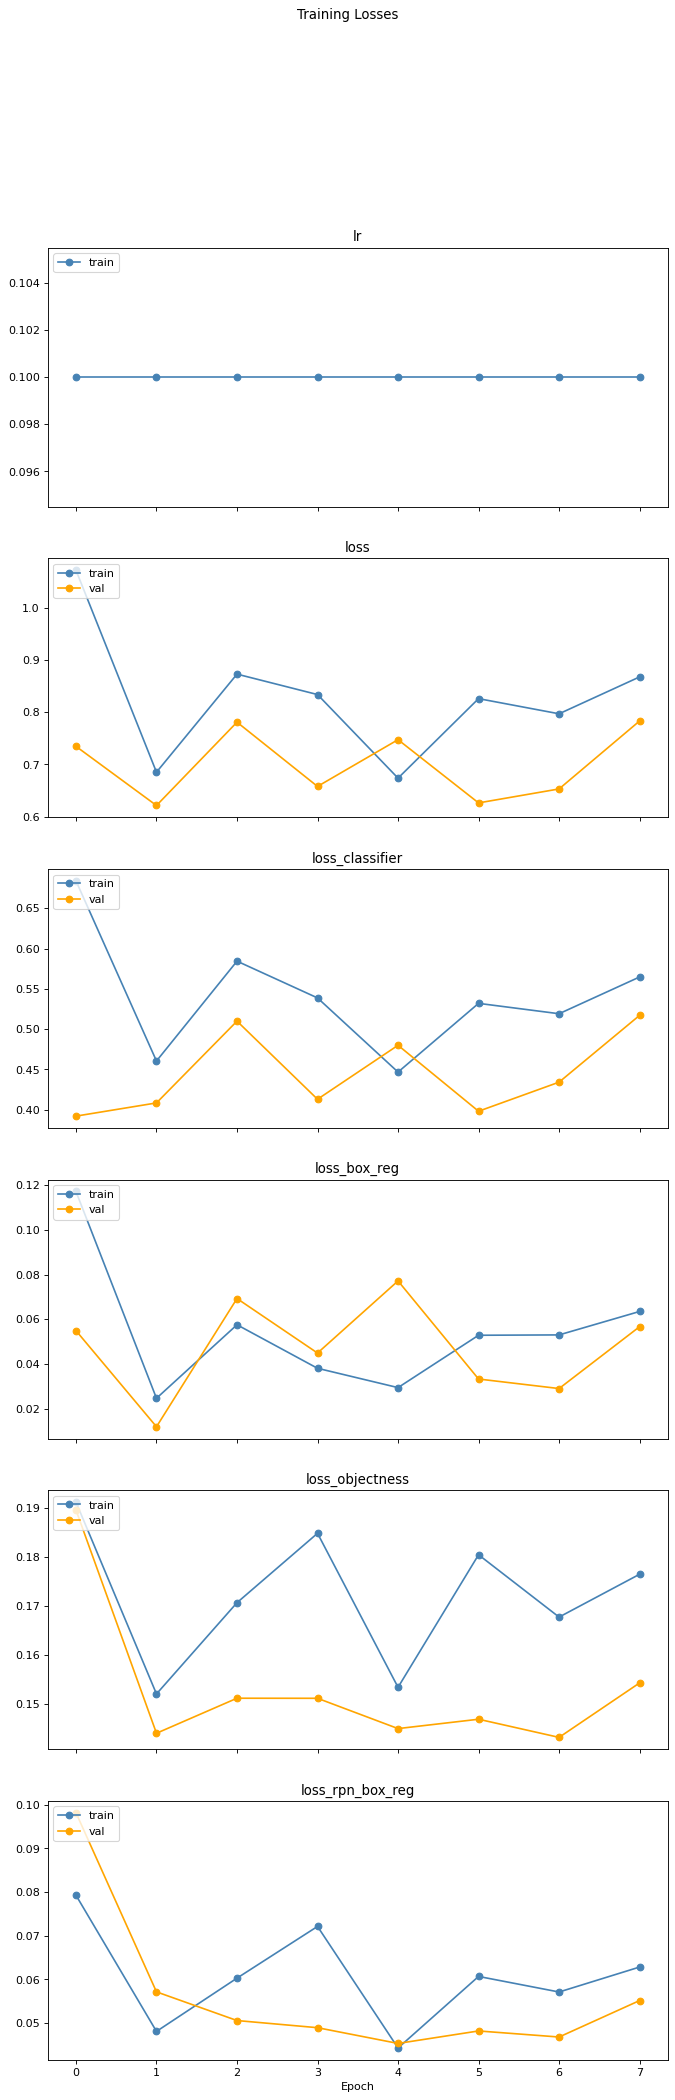

====================| Epoch [8] Done | It has took [12.93] min, Avg time: [97.00] sec/epoch | Estimate time for [100] epochs: [161.67] min | Epoch took [95] sec |====================
====================Training model: [mobilenet_v3_no_pretrained_no_lr_scheduler]====================
Epoch: [9]  [  0/118]  eta: 0:01:34  lr: 0.100000  loss: 0.2709 (0.2709)  loss_classifier: 0.1818 (0.1818)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0891 (0.0891)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.8046  data: 0.5362  max mem: 1437
Epoch: [9]  [ 10/118]  eta: 0:01:17  lr: 0.100000  loss: 0.5911 (0.6565)  loss_classifier: 0.4024 (0.4216)  loss_box_reg: 0.0012 (0.0563)  loss_objectness: 0.1459 (0.1458)  loss_rpn_box_reg: 0.0412 (0.0329)  time: 0.7202  data: 0.5408  max mem: 1437
Epoch: [9]  [ 20/118]  eta: 0:01:09  lr: 0.100000  loss: 0.5911 (0.6142)  loss_classifier: 0.4024 (0.3965)  loss_box_reg: 0.0003 (0.0352)  loss_objectness: 0.1459 (0.1462)  loss_rpn_box_reg: 0.0412 (0.0363)  time: 0.

KeyboardInterrupt: 

In [12]:
train_info = TrainingInfo(model_setup)

model = create_model_from_setup(
        labels_cols,
        model_setup,
        rpn_nms_thresh=0.3,
        box_detections_per_img=10,
        box_nms_thresh=0.2,
        rpn_score_thresh=0.0,
        box_score_thresh=0.05,
    )

print_params_setup(model)

model.to(device)

iou_types = get_iou_types(model, model_setup)
optimizer = get_optimiser(model, model_setup)
lr_scheduler = get_lr_scheduler(optimizer, model_setup)

current_time = datetime.now()

print_f.print_title(
    f"Start training. Preparing Tooke [{ (current_time - train_info.start_t).seconds}] sec"
)

train_info.start_t = datetime.now()

val_ap_ar = None

## Start the training from here.
for e in range(num_epochs):

    print_f.print_title(f"Training model: [{model_setup.name}]")

    train_info.epoch = e + 1

    ###### Perform training and show the training result here ######
    model.train()

    train_info.last_train_evaluator, train_loger = xami_train_one_epoch(
        model=model,
        optimizer=optimizer,
        data_loader=train_dataloader,
        device=device,
        epoch=train_info.epoch,
        print_freq=10,
        iou_types=iou_types,
        coco=train_coco,
        score_thres=None,
        evaluate_on_run=True,
        params_dict=eval_params_dict,
    )

    # train_info.train_evaluators.append(train_evaluator)
    train_info.train_data.append(get_data_from_metric_logger(train_loger))
    ################################################################

    ### update the learning rate
    # if not warmup_scheduler is None and train_info.epoch <= model_setup.warmup_epoch:
    #     warmup_scheduler.step()
    # else:
    if train_info.epoch> model_setup.warmup_epochs:
        if not lr_scheduler is None:
            if isinstance(lr_scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                lr_scheduler.step(val_ap_ar["ap"] if not val_ap_ar is None else 0)
            else:
                lr_scheduler.step()

    ####### Put the model into evaluation mode, start evaluating the current model #######
    model.eval()

    train_info.last_val_evaluator, val_logger = xami_evaluate(
        model=model,
        data_loader=val_dataloader,
        device=device,
        params_dict=eval_params_dict,
        coco=val_coco,
        iou_types=iou_types,
        score_thres=None,
    )

    # train_info.val_evaluators.append(val_evaluator)
    train_info.val_data.append(get_data_from_metric_logger(val_logger))

    train_ap_ar, val_ap_ar = get_ap_ar_for_train_val(
        train_info.last_train_evaluator,
        train_info.last_val_evaluator,
        areaRng="all",
        iouThr=0.5,
        maxDets=10,
    )

    train_info.train_ap_ars.append(train_ap_ar)
    train_info.val_ap_ars.append(val_ap_ar)

    ## Clean everything before we show the evaluating result in this stage, so we can inspect the training progress.
    clear_output()

    # if model_setup.record_training_performance:
    plot_train_val_ap_ars(
        train_ap_ars=train_info.train_ap_ars, val_ap_ars=train_info.val_ap_ars,
    )

    plot_losses(train_info.train_data, train_info.val_data)

    previous_time = current_time
    current_time = datetime.now()
    epoch_took = current_time - previous_time

    sec_took = (current_time - train_info.start_t).seconds
    speed = sec_took / train_info.epoch

    print_f.print_title(
        f"| Epoch [{train_info.epoch}] Done | It has took [{sec_took/60:.2f}] min, Avg time: [{speed:.2f}] sec/epoch | Estimate time for [{num_epochs}] epochs: [{speed*num_epochs/60:.2f}] min | Epoch took [{epoch_took.seconds}] sec |"
    )

    #######################################################################################
    if model_setup.use_early_stop_model:
        val_ar, val_ap, train_info = check_best(
            device=device,
            eval_params_dict=eval_params_dict,
            train_info=train_info,
            model=model,
            optim=optimizer,
            test_dataloader=test_dataloader,
            test_coco=test_coco,
            iou_types=iou_types,
            score_thres=None,
        )

val_ar, val_ap = get_ar_ap(train_info.last_val_evaluator)

train_info = end_train(
    train_info=train_info,
    model=model,
    optim=optimizer,
    eval_params_dict=eval_params_dict,
    last_val_ar=val_ar,
    last_val_ap=val_ap,
    test_dataloader=test_dataloader,
    device=device,
    test_coco=test_coco,
    iou_types=iou_types,
    score_thres=None,
)


In [ ]:
val_ar, val_ap = get_ar_ap(train_info.last_val_evaluator)

train_info = end_train(
    train_info=train_info,
    model=model,
    optim=optimizer,
    eval_params_dict=eval_params_dict,
    last_val_ar=val_ar,
    last_val_ap=val_ap,
    test_dataloader=test_dataloader,
    device=device,
    test_coco=test_coco,
    iou_types=iou_types,
    score_thres=None,
)

====================| Training Done, start testing! | [70] Epochs Training time: [6853] seconds, Avg time / Epoch: [97.9] seconds====================
====================Best AP validation model has been saved to: [val_ar_0_8951_ap_0_3427_test_ar_0_7418_ap_0_2859_epoch50_WithClincal_05-01-2022 05-44-29_mobilenet_v3_no_pretrained_no_lr_scheduler]====================
====================Best AR validation model has been saved to: [val_ar_0_8951_ap_0_3296_test_ar_0_7686_ap_0_2882_epoch42_WithClincal_05-01-2022 05-31-36_mobilenet_v3_no_pretrained_no_lr_scheduler]====================
Evaluation:  [ 0/15]  eta: 0:00:13  loss: 2.0095 (2.0095)  loss_classifier: 0.8244 (0.8244)  loss_box_reg: 0.0587 (0.0587)  loss_objectness: 0.6833 (0.6833)  loss_rpn_box_reg: 0.4431 (0.4431)  model_time: 0.1359 (0.1359)  evaluator_time: 0.0020 (0.0020)  time: 0.8961  data: 0.5071  max mem: 1262
Evaluation:  [14/15]  eta: 0:00:00  loss: 1.4509 (1.4377)  loss_classifier: 0.5289 (0.5129)  loss_box_reg: 0.0346 (0.

========================================For Training [mobilenet_v3_no_pretrained_no_lr_scheduler]========================================
ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='mobilenet_v3_no_pretrained_no_lr_scheduler', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='mobilenet_v3', optimiser='sgd', lr=1e-05, weight_decay=0.001, pretrained=True, record_training_performance=True, dataset_mode='unified', image_size=256, backbone_out_channels=16, batch_size=4, warmup_epochs=0, lr_scheduler=None, reduceLROnPlateau_factor=0.1, reduceLROnPlateau_patience=3, multiStepLR_milestones=[30, 50, 70, 90], multiStepLR_gamma=0.1, representation_size=32, mask_hidden_layers=256, using_fpn=False, use_mask=False, clinical_expand_dropout_rate=0, clinical_conv_dropout_rate=0, clinical_input_channels=32, clinical_num_len=9, clinical_conv_channels=32, fuse_conv_channels=32, fuse_dropout_rate=0, box_head_dropout_rate=0, 

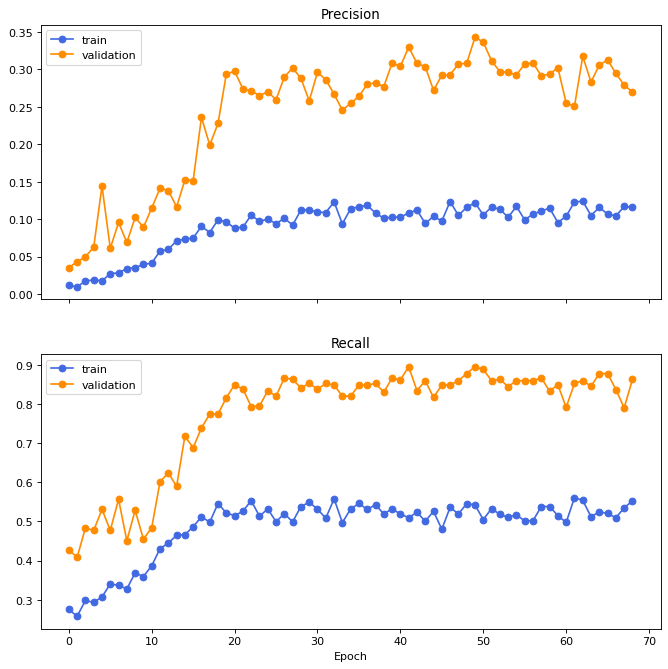

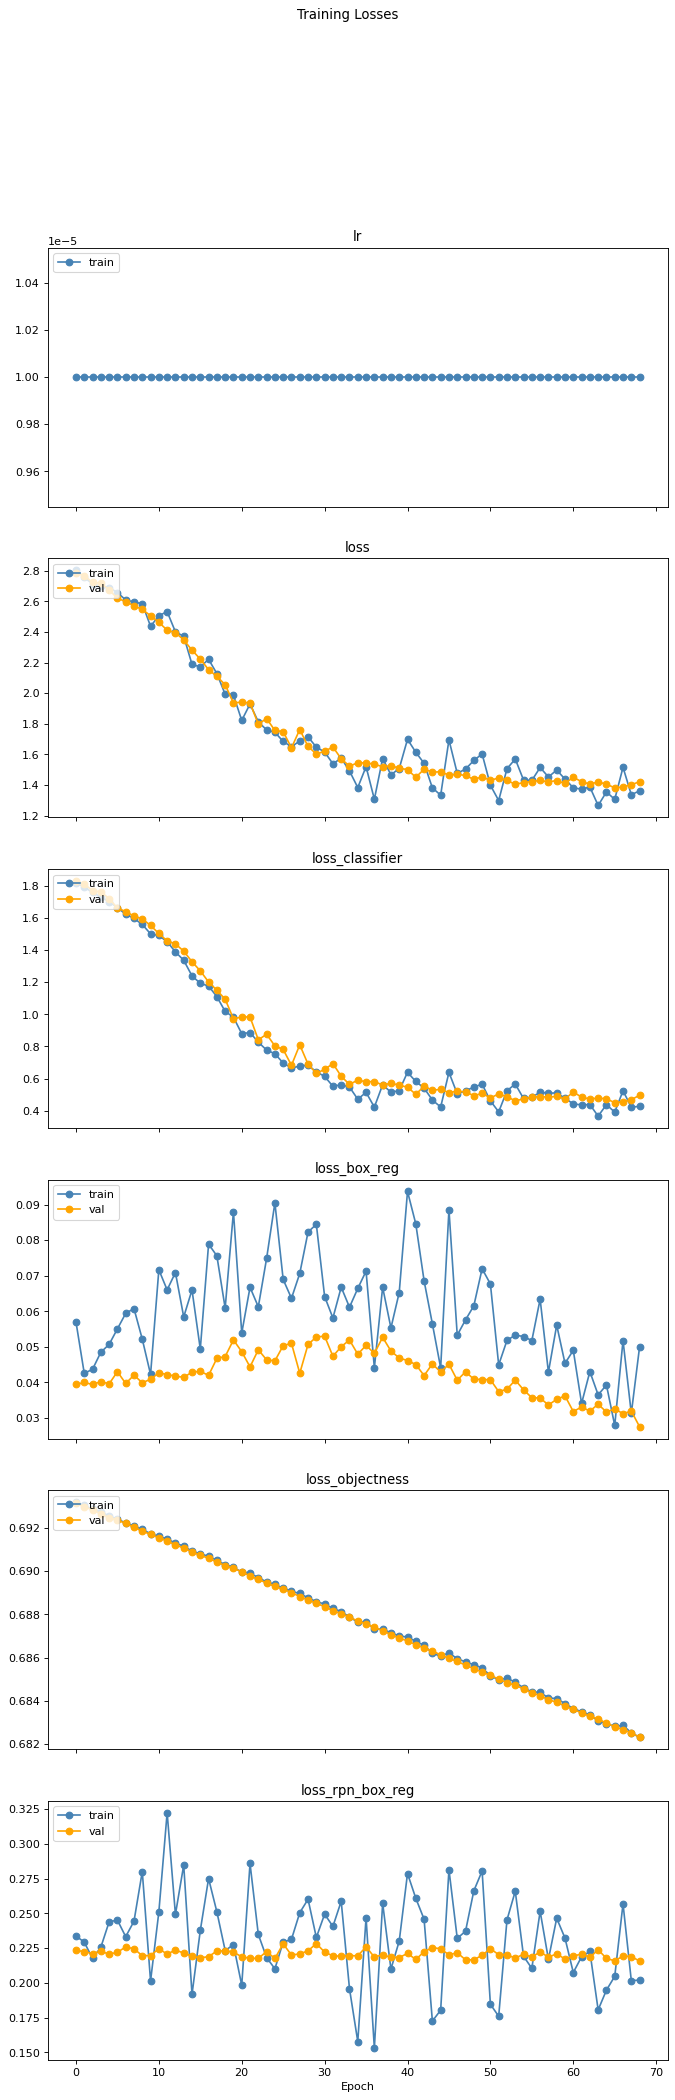

In [ ]:
print(train_info)
model_setup = train_info.model_setup
model = create_model_from_setup(
    labels_cols,
    model_setup,
    rpn_nms_thresh=0.3,
    box_detections_per_img=10,
    box_nms_thresh=0.2,
    rpn_score_thresh=0.0,
    box_score_thresh=0.05,
)
print_params_setup(model)
plot_train_val_ap_ars(train_info.train_ap_ars, train_info.val_ap_ars)
plot_losses(train_info.train_data, train_info.val_data)